# Задача 2. Линейная регрессия, метод градиентного спуска

## Задача

- Самостоятельно реализовать функцию **gradient_descent(X, y)**, которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал **методом градиентного спуска (Batch Gradient Descent, GD)** и возвращая вектор весов **w**. В качестве функционала можно выбрать, например, функцию ошибок **MSE** + $L_2$-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.
- Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целевого признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат. В крайнем случае взять данные для предсказания стоимости машин [тут](https://github.com/rustam-azimov/ml-course-itmo/tree/main/data/car_price) (целевой признак для предсказания: **price**).
- Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.
- При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- Случайным образом разбить данные на **обучающую** и **тестовую** выборки, используя методы существующих библиотек.
- При обучении моделей использовать **масштабирование данных**.
- Обучить модель на обучающей выборке, используя функцию **gradient_descent(X, y)**. Оценить качество модели на обучающей и тестовой выборках, используя **MSE**, **RMSE** и $R^2$.
- Обучить модель, используя существующую библиотеку. Например, в **sklearn** для $L_2$-регуляризатора можно использовать **Ridge**. Сравнить качество с Вашей реализацией.
- Повторить тоже самое, но используя **кросс-валидацию**.
- Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k: количество фолдов в кросс-валидации, **E**: мат. ожидание и **STD**: стандартное отклонение. Сделать выводы.

* (+2 балла) Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя **Recursive Feature Elimination (RFE)** из **sklearn**.
* (+1 балл) Во все ваши реализации добавить возможность настройки нужных **гиперпараметров**, а в процессе обучения **всех** моделей осуществить подбор оптимальных значений этих гиперпараметров.
* (+1 балл) Также самостоятельно реализовать **метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD)**, обучить модели и добавить их во все сравнения.
* (+1 балл) Также самостоятельно реализовать **метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent)**, обучить модели и добавить их во все сравнения.

## Градиентный спуск

Реализация полного, mini-batch и стохастического градиентных спусков с функцией ошибок MSE и $L_2$-регуляризатором

In [1]:
from abc import ABC, abstractmethod
import numpy as np
from math import ceil


class LinearRegressionBase(ABC):
    def __init__(self, tol=1e-6, alpha=1, max_iter=1000):
        self.alpha = alpha
        self.iter = 0
        self.max_iter = max_iter
        self.tol = tol

    @abstractmethod
    def get_batch(self, X, y):
        ...

    def fit(self, X, y):
        X = np.column_stack([X, np.ones(X.shape[0])])
        coef = np.zeros(X.shape[1])
        grad = np.inf

        while self.iter < self.max_iter and np.linalg.norm(grad) > self.tol:
            X_batch, y_batch = self.get_batch(X, y)
            pred = X_batch.dot(coef)
            grad = (1 / X_batch.shape[0]) * (
                X_batch.T.dot(pred - y_batch) + self.alpha * coef
            )

            self.iter += 1
            coef -= grad / self.iter

        self.coef = coef[:-1]
        self.intercept = coef[-1]

        return self

    def predict(self, X):
        return X.dot(self.coef) + self.intercept


class LinearRegressionGD(LinearRegressionBase):
    def get_batch(self, X, y):
        return X, y


class LinearRegressionBatchSizeable(LinearRegressionBase):
    def __init__(
        self, tol=1e-6, alpha=1, max_iter=1000, batch_size_func=lambda X_size: 1
    ):
        super().__init__(tol=tol, alpha=alpha, max_iter=max_iter)
        self.batch_size_func = batch_size_func

    def get_batch(self, X, y):
        idx = np.random.randint(len(X), size=self.batch_size_func(len(X)))
        return X[idx, :], y[idx]


class LinearRegressionMBGD(LinearRegressionBatchSizeable):
    def __init__(self, tol=1e-6, alpha=1, max_iter=1000, batch_size=0.1):
        super().__init__(
            tol=tol,
            alpha=alpha,
            max_iter=max_iter,
            batch_size_func=lambda X_size: ceil(X_size * batch_size),
        )


class LinearRegressionSGD(LinearRegressionBatchSizeable):
    def __init__(self, tol=1e-6, alpha=1, max_iter=1000):
        super().__init__(
            tol=tol, alpha=alpha, max_iter=max_iter, batch_size_func=lambda _: 1
        )


## Подготовка датасета

Датасет: [car_price](https://github.com/rustam-azimov/ml-course-itmo/tree/main/data/car_price)

Признаки:
- car_ID: ID машины
- symboling: уровень риска авто (ниже -> безопаснее)
- CarName: наименование машины
- fueltype: тип топлива
- aspiration: тип наддува
- doornumber: количество дверей
- carbody: тип кузова
- drivewheel: тип привода
- enginelocation: расположение мотора
- wheelbase: колёсная база автомобиля в дюймах
- carlenght: длина автомобиля в дюймах
- carwidth: ширина автомобиля в дюймах
- curbweight: вес автомобиля в фунтах
- enginetype: тип двигателя автомобиля
- cylindernumber: количество цилиндров
- enginesize: размер двигателя в кубических дюймах
- fuelsystem: тип топливной системы
- boreratio: соотношение диаметра цилиндра и хода
- stroke: ход поршня
- compessionratio: степень сжатия цилиндра
- horsepower: мощность в лошадиных силах
- peakrpm: максимальное количество оборотов в минуту
- citympg: расход топлива в городе (миль на галлон)
- highwaympg: расход топлива на трассе (миль на галлон)
- price: цена автомобиля (целевой признак)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = "{:.3f}".format


df = pd.read_csv("../../data/car_price/car_price.csv")
df = df.drop(columns=["car_ID"])
df.head()


,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.600,168.800,...,130,mpfi,3.470,2.680,9.000,111,5000,21,27,13495.000
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.600,168.800,...,130,mpfi,3.470,2.680,9.000,111,5000,21,27,16500.000
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.500,171.200,...,152,mpfi,2.680,3.470,9.000,154,5000,19,26,16500.000
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.800,176.600,...,109,mpfi,3.190,3.400,10.000,102,5500,24,30,13950.000
4,2,audi 100ls,gas,std,four,sedan,4wd,front,99.400,176.600,...,136,mpfi,3.190,3.400,8.000,115,5500,18,22,17450.000


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

Из пяти первых строк датасета видно, что признак `CarName` не всегда корректен.

In [4]:
df[:5].get("CarName")

0          alfa-romero giulia
1         alfa-romero stelvio
2    alfa-romero Quadrifoglio
3                 audi 100 ls
4                  audi 100ls
Name: CarName, dtype: object

Добавим признак `Manufacturer` - отвечающий за производителя. В признаке `CarName` оставим только наименование модели без пробелов.

In [5]:
df["Manufacturer"] = df["CarName"].str.split(" ").str[0].str.lower()
df["CarName"] = df["CarName"].str.split(" ").str[1:].str.join("").str.lower()

cols = df.columns.tolist()
cols = cols[:2] + [cols[-1]] + cols[2:-1]
df = df[cols]

df.head()


,symboling,CarName,Manufacturer,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,giulia,alfa-romero,gas,std,two,convertible,rwd,front,88.600,...,130,mpfi,3.470,2.680,9.000,111,5000,21,27,13495.000
1,3,stelvio,alfa-romero,gas,std,two,convertible,rwd,front,88.600,...,130,mpfi,3.470,2.680,9.000,111,5000,21,27,16500.000
2,1,quadrifoglio,alfa-romero,gas,std,two,hatchback,rwd,front,94.500,...,152,mpfi,2.680,3.470,9.000,154,5000,19,26,16500.000
3,2,100ls,audi,gas,std,four,sedan,fwd,front,99.800,...,109,mpfi,3.190,3.400,10.000,102,5500,24,30,13950.000
4,2,100ls,audi,gas,std,four,sedan,4wd,front,99.400,...,136,mpfi,3.190,3.400,8.000,115,5500,18,22,17450.000


Некоторые производители по разному записаны, унифицируем их названия.

In [6]:
df["Manufacturer"].unique()


array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

In [7]:
df["Manufacturer"] = df["Manufacturer"].replace(
    {
        "maxda": "mazda",
        "porcshce": "porsche",
        "toyouta": "toyota",
        "vokswagen": "volkswagen",
        "vw": "volkswagen",
    }
)
df.replace()


,symboling,CarName,Manufacturer,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,giulia,alfa-romero,gas,std,two,convertible,rwd,front,88.600,...,130,mpfi,3.470,2.680,9.000,111,5000,21,27,13495.000
1,3,stelvio,alfa-romero,gas,std,two,convertible,rwd,front,88.600,...,130,mpfi,3.470,2.680,9.000,111,5000,21,27,16500.000
2,1,quadrifoglio,alfa-romero,gas,std,two,hatchback,rwd,front,94.500,...,152,mpfi,2.680,3.470,9.000,154,5000,19,26,16500.000
3,2,100ls,audi,gas,std,four,sedan,fwd,front,99.800,...,109,mpfi,3.190,3.400,10.000,102,5500,24,30,13950.000
4,2,100ls,audi,gas,std,four,sedan,4wd,front,99.400,...,136,mpfi,3.190,3.400,8.000,115,5500,18,22,17450.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,145e(sw),volvo,gas,std,four,sedan,rwd,front,109.100,...,141,mpfi,3.780,3.150,9.500,114,5400,23,28,16845.000
201,-1,144ea,volvo,gas,turbo,four,sedan,rwd,front,109.100,...,141,mpfi,3.780,3.150,8.700,160,5300,19,25,19045.000
202,-1,244dl,volvo,gas,std,four,sedan,rwd,front,109.100,...,173,mpfi,3.580,2.870,8.800,134,5500,18,23,21485.000
203,-1,246,volvo,diesel,turbo,four,sedan,rwd,front,109.100,...,145,idi,3.010,3.400,23.000,106,4800,26,27,22470.000


<AxesSubplot: xlabel='price', ylabel='Count'>

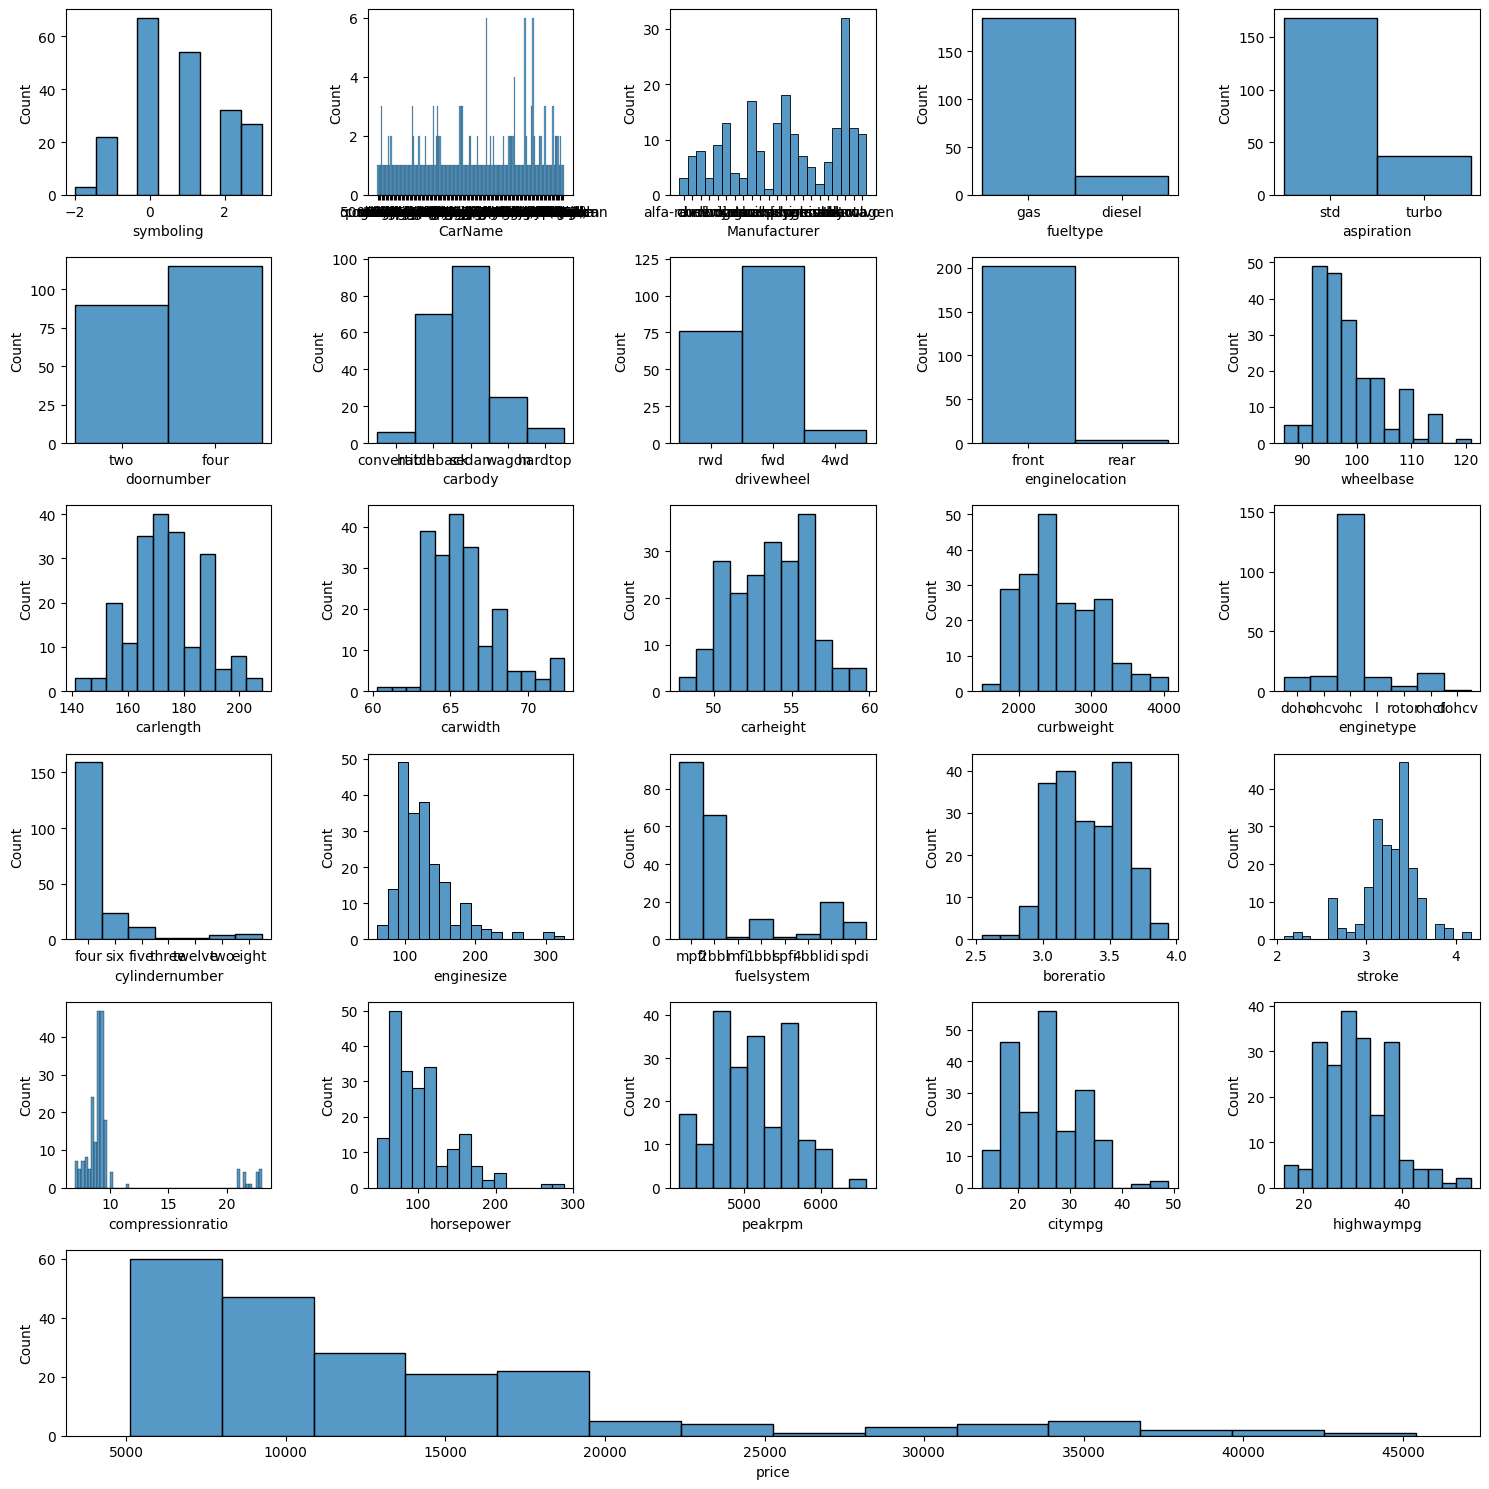

In [8]:
list(df.columns)

fig = plt.figure(figsize=(15, 15), tight_layout=True)
gs = fig.add_gridspec(6, 5)
for i in range(5):
    for j in range(5):
        sns.histplot(df[df.columns[5 * i + j]], ax=fig.add_subplot(gs[i, j]))
sns.histplot(df["price"], ax=fig.add_subplot(gs[5, :]))


Почти все машины используют бензин, имеют стандартный тип наддува. Двигатели почти у всех машин расположены спереди. Количество цилиндров - 4.

Средняя цена автомобиля:

In [9]:
df["price"].mean()


13276.710570731706

Приведём не числовые аттрибуты к числовым.

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
categorical_cols = df.select_dtypes(include=["object"]).columns

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

df.head()


,symboling,CarName,Manufacturer,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,76,0,1,0,1,0,2,0,88.600,...,130,5,3.470,2.680,9.000,111,5000,21,27,13495.000
1,3,122,0,1,0,1,0,2,0,88.600,...,130,5,3.470,2.680,9.000,111,5000,21,27,16500.000
2,1,106,0,1,0,1,2,2,0,94.500,...,152,5,2.680,3.470,9.000,154,5000,19,26,16500.000
3,2,1,1,1,0,0,3,1,0,99.800,...,109,5,3.190,3.400,10.000,102,5500,24,30,13950.000
4,2,1,1,1,0,0,3,0,0,99.400,...,136,5,3.190,3.400,8.000,115,5500,18,22,17450.000


Корреляцию аттрибутов:

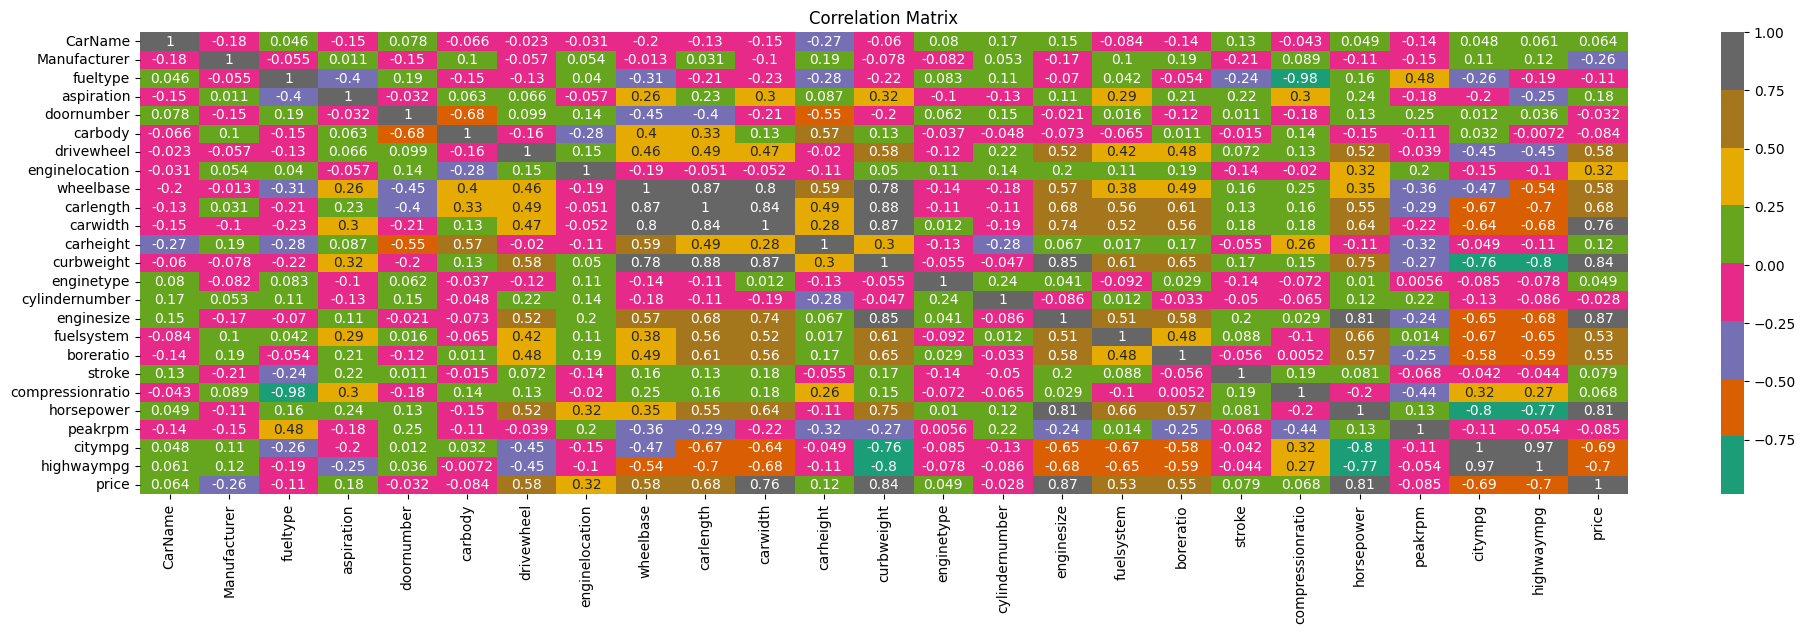

In [11]:
df_corr = df.drop(columns=["symboling"]).corr()
plt.figure(figsize=(24, 6))
sns.heatmap(df_corr, annot=True, cmap="Dark2")
plt.title("Correlation Matrix")
plt.show()


Можно выделить связанные между собой признаки:
- `wheelbase`, `carlength`, `carwidth`, `curbweight`
- `compressionratio`, `fueltype`
- `curbweight`, `eigensize`, `horsepower`

`price` коррелирует с `carwidth`, `curbweight`, `eigensize`, `horsepower`.

`price` слабо коррелирует с `CarName`, `doornumber`, `carbody`, `enginetype`, `cylindernumber`, `stroke`, `compressionratio`, `peakrpm`.

## Подготовка датасета

### Маштабирование признаков

In [12]:
from sklearn.preprocessing import StandardScaler

x, y = df.drop(columns=["price"]), df["price"]
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
x.head()


,symboling,CarName,Manufacturer,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,1.743,0.268,-1.945,0.329,-0.469,1.130,-3.051,1.213,-0.122,-1.691,...,-0.147,0.074,0.870,0.519,-1.839,-0.288,0.174,-0.263,-0.647,-0.546
1,1.743,1.420,-1.945,0.329,-0.469,1.130,-3.051,1.213,-0.122,-1.691,...,-0.147,0.074,0.870,0.519,-1.839,-0.288,0.174,-0.263,-0.647,-0.546
2,0.134,1.019,-1.945,0.329,-0.469,1.130,-0.717,1.213,-0.122,-0.709,...,1.112,0.604,0.870,-2.405,0.686,-0.288,1.265,-0.263,-0.953,-0.692
3,0.938,-1.610,-1.786,0.329,-0.469,-0.885,0.450,-0.589,-0.122,0.174,...,-0.147,-0.431,0.870,-0.517,0.462,-0.036,-0.054,0.788,-0.187,-0.109
4,0.938,-1.610,-1.786,0.329,-0.469,-0.885,0.450,-2.391,-0.122,0.107,...,-1.407,0.219,0.870,-0.517,0.462,-0.541,0.276,0.788,-1.106,-1.274


### Выбор наилучшего подмножества признаков

In [13]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

rfecv = RFECV(estimator=LinearRegression())
rfecv.fit(x, y)

best_cols = list(x.columns[rfecv.support_])
print("Достаточное число атрибутов:", rfecv.n_features_)
print("Наиболее важные атрибуты:", *best_cols)


Достаточное число атрибутов: 1
Наиболее важные атрибуты: enginesize


"Топ" атрибутов

In [14]:
rank_list = list(zip(rfecv.ranking_, x.columns.values))
rank_list.sort()
rank_list


[(1, 'enginesize'),
 (2, 'carwidth'),
 (3, 'enginelocation'),
 (4, 'curbweight'),
 (5, 'Manufacturer'),
 (6, 'horsepower'),
 (7, 'wheelbase'),
 (8, 'stroke'),
 (9, 'compressionratio'),
 (10, 'peakrpm'),
 (11, 'CarName'),
 (12, 'carbody'),
 (13, 'carheight'),
 (14, 'highwaympg'),
 (15, 'citympg'),
 (16, 'drivewheel'),
 (17, 'fueltype'),
 (18, 'aspiration'),
 (19, 'carlength'),
 (20, 'doornumber'),
 (21, 'fuelsystem'),
 (22, 'enginetype'),
 (23, 'cylindernumber'),
 (24, 'symboling'),
 (25, 'boreratio')]

Для более интересных результатов возьмём первые пять признаков из списка: `enginesize`, `carwidth`, `enginelocation`, `curbweight`, `Manufacturer`.

In [15]:
x = x[[r[1] for r in rank_list[:5]]]
x.head()


,enginesize,carwidth,enginelocation,curbweight,Manufacturer
0,0.074,-0.845,-0.122,-0.015,-1.945
1,0.074,-0.845,-0.122,-0.015,-1.945
2,0.604,-0.191,-0.122,0.515,-1.945
3,-0.431,0.137,-0.122,-0.421,-1.786
4,0.219,0.230,-0.122,0.517,-1.786


### Разбиение данных на тренировные и тестовые

In [16]:
from sklearn.model_selection import train_test_split

x_np = x.to_numpy()
y_np = y.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
x_train_np, x_test_np, y_train_np, y_test_np = [
    np.array(t) for t in [x_train, x_test, y_train, y_test]
]


### Подбор гиперпараметров

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

alpha_grid = np.logspace(-5, 5, 300)
tol_grid = np.logspace(-4, 1, 10)


searcher = GridSearchCV(
    Ridge(),
    [{"alpha": alpha_grid, "tol": tol_grid}],
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=4,
)
searcher.fit(x_train, y_train)

opt_alpha = searcher.best_params_["alpha"]
opt_tol = searcher.best_params_["tol"]

print(f"Лучшее значение alpha = {opt_alpha}")
print(f"Точность решения tol = {opt_tol}")


Лучшее значение alpha = 1e-05
Точность решения tol = 0.0001


## Обучение моделей

In [18]:
models = {
    "Gradient": LinearRegressionGD(alpha=opt_alpha, tol=opt_tol),
    "SGD": LinearRegressionSGD(alpha=opt_alpha, tol=opt_tol),
    "MBGD": LinearRegressionMBGD(
        alpha=opt_alpha, tol=opt_tol, batch_size=x_train_np.shape[0] // 8
    ),
    "Ridge": Ridge(alpha=opt_alpha, tol=opt_tol),
}

predicts = {}
for _, model in models.items():
    model.fit(x_train_np, y_train_np)


### Оценка моделей с помощью MSE, RMSE и R2

In [19]:
from sklearn.metrics import mean_squared_error, r2_score


def print_results(y_train, y_train_pred, y_test, y_test_pred):
    print("Test RMSE =", mean_squared_error(y_test, y_test_pred, squared=False))
    print("Train RMSE =", mean_squared_error(y_train, y_train_pred, squared=False))
    print("Test MSE =", mean_squared_error(y_test, y_test_pred, squared=True))
    print("Train MSE =", mean_squared_error(y_train, y_train_pred, squared=True))
    print("Test R^2 =", r2_score(y_test, y_test_pred))
    print("Train R^2 =", r2_score(y_train, y_train_pred))
    print("------------------")


for name, model in models.items():
    print(f"Model {name}")
    y_train_pred = model.predict(x_train_np)
    y_test_pred = model.predict(x_test_np)

    predicts[name] = (y_train_pred, y_test_pred)
    print_results(y_train_np, y_train_pred, y_test_np, y_test_pred)


Model Gradient
Test RMSE = 3653.6225102068943
Train RMSE = 2565.5044410876
Test MSE = 13348957.447090529
Train MSE = 6581813.037240197
Test R^2 = 0.8299447334286149
Train R^2 = 0.8864811697273528
------------------
Model SGD
Test RMSE = 7652.237046666923
Train RMSE = 5929.470039224545
Test MSE = 58556731.818381704
Train MSE = 35158614.94606153
Test R^2 = 0.25403308247908296
Train R^2 = 0.3936070775482189
------------------
Model MBGD
Test RMSE = 3656.3891099908833
Train RMSE = 2565.653207524289
Test MSE = 13369181.323659923
Train MSE = 6582576.381279672
Test R^2 = 0.8296870970750085
Train R^2 = 0.88646800406586
------------------
Model Ridge
Test RMSE = 3649.0956669935986
Train RMSE = 2565.4370766431775
Test MSE = 13315899.186871456
Train MSE = 6581467.394215493
Test R^2 = 0.8303658697814891
Train R^2 = 0.886487131153427
------------------


### Визуализация результата

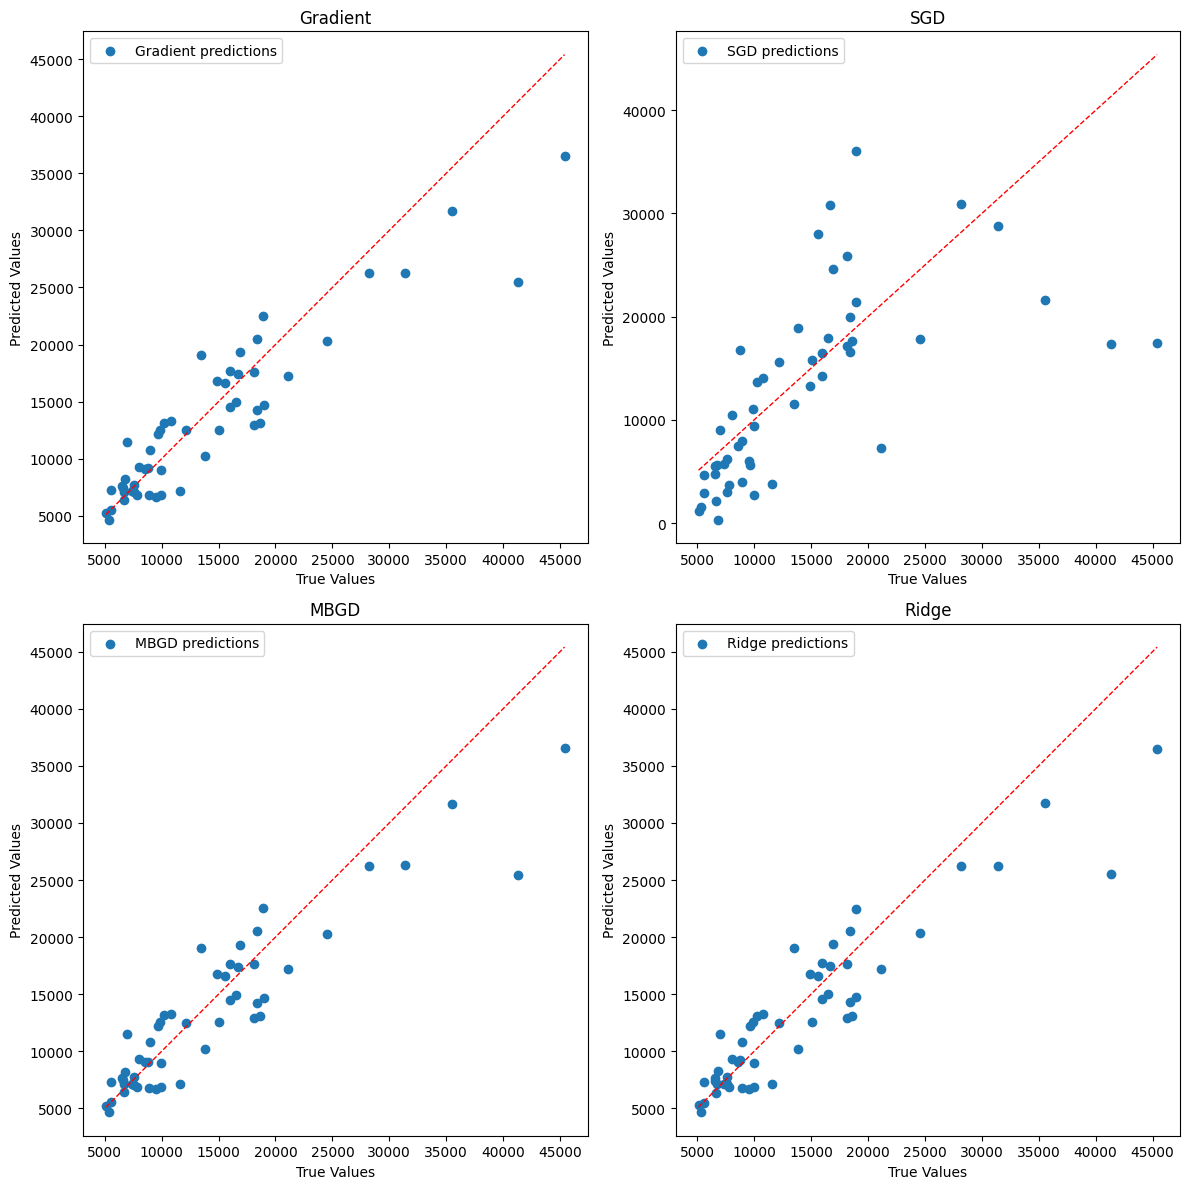

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.ravel()

for i, model_name in enumerate(predicts):
    ax[i].scatter(y_test, predicts[model_name][1], label=f"{model_name} predictions")
    ax[i].set_title(model_name)

for a in ax:
    a.set_xlabel("True Values")
    a.set_ylabel("Predicted Values")
    a.plot(
        [np.min(y_test), np.max(y_test)],
        [np.min(y_test), np.max(y_test)],
        color="red",
        linewidth=1,
        ls="--",
    )
    a.legend()

plt.tight_layout()
plt.show()


In [22]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5)

results_df = pd.DataFrame(
    index=[
        "mse-train",
        "mse-test",
        "rmse-train",
        "rmse-test",
        "r2-train",
        "r2-test",
    ]
)

results = {
    "Gradient": results_df.copy(),
    "SGD": results_df.copy(),
    "MBGD": results_df.copy(),
    "Ridge": results_df.copy(),
}

models = {
    "Gradient": LinearRegressionGD(alpha=opt_alpha, tol=opt_tol),
    "SGD": LinearRegressionSGD(alpha=opt_alpha, tol=opt_tol),
    "MBGD": LinearRegressionMBGD(
        alpha=opt_alpha, tol=opt_tol, batch_size=x_train_np.shape[0] // 8
    ),
    "Ridge": Ridge(alpha=opt_alpha, tol=opt_tol),
}

for name, model in models.items():
    for fold_i, (train_i, test_i) in enumerate(fold.split(X=x_train, y=y_train)):
        cur_x_train = x_np[train_i, :]
        cur_x_test = x_np[test_i, :]
        cur_y_train = y_np[train_i]
        cur_y_test = y_np[test_i]
        model.fit(cur_x_train, cur_y_train)

        y_pred_train = model.predict(cur_x_train)
        y_pred_test = model.predict(cur_x_test)

        mse_train = mean_squared_error(cur_y_train, y_pred_train, squared=True)
        mse_test = mean_squared_error(cur_y_test, y_pred_test, squared=True)

        rmse_train = mean_squared_error(cur_y_train, y_pred_train, squared=False)
        rmse_test = mean_squared_error(cur_y_test, y_pred_test, squared=False)

        r2_train = r2_score(cur_y_train, y_pred_train)
        r2_test = r2_score(cur_y_test, y_pred_test)

        results[name].insert(
            loc=fold_i,
            column=f"Fold{fold_i + 1}",
            value=[mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test],
        )

    results[name]["E"] = results[name].mean(axis=1)
    results[name]["STD"] = results[name].std(axis=1)


In [23]:
results["Gradient"]


,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,6806931.885,285902579.665,235960348.752,291084079.819,267534289.873,217457645.999,107078760.106
mse-test,18635991.739,192592763.919,389139608.161,168238286.100,264792424.875,206679814.959,121412789.414
rmse-train,2609.010,16908.654,15361.001,17061.186,16356.475,13659.265,5557.168
rmse-test,4316.942,13877.780,19726.622,12970.670,16272.444,13432.892,5122.230
r2-train,0.911,-2.592,-2.728,-2.185,-2.437,-1.806,1.370
r2-test,0.771,-2.011,-2.036,-7.610,-2.390,-2.655,2.726


In [24]:
results["SGD"]


,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,87827465.516,285902579.665,235960348.752,291084079.819,267534289.873,233661752.725,75427712.799
mse-test,271876471.490,192592763.919,389139608.161,168238286.100,264792424.875,257327910.909,77161264.402
rmse-train,9371.631,16908.654,15361.001,17061.186,16356.475,15011.790,2882.348
rmse-test,16488.677,13877.780,19726.622,12970.670,16272.444,15867.238,2357.680
r2-train,-0.152,-2.592,-2.728,-2.185,-2.437,-2.019,0.951
r2-test,-2.342,-2.011,-2.036,-7.610,-2.390,-3.278,2.171


In [25]:
results["MBGD"]


,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,6819317.191,285902579.665,235960348.752,291084079.819,267534289.873,217460123.060,107073887.111
mse-test,18361068.602,192592763.919,389139608.161,168238286.100,264792424.875,206624830.332,121497969.388
rmse-train,2611.382,16908.654,15361.001,17061.186,16356.475,13659.740,5556.225
rmse-test,4284.982,13877.780,19726.622,12970.670,16272.444,13426.499,5133.609
r2-train,0.911,-2.592,-2.728,-2.185,-2.437,-1.806,1.370
r2-test,0.774,-2.011,-2.036,-7.610,-2.390,-2.654,2.727


In [26]:
results["Ridge"]


,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,6739419.587,8944519.500,9417689.550,7972781.863,8198553.403,8254592.781,917289.549
mse-test,20544906.231,9415548.588,7129444.397,17092210.390,52124368.841,21261295.689,16189223.056
rmse-train,2596.039,2990.739,3068.825,2823.611,2863.312,2868.505,162.080
rmse-test,4532.649,3068.477,2670.102,4134.273,7219.721,4325.044,1598.527
r2-train,0.912,0.888,0.851,0.913,0.895,0.892,0.022
r2-test,0.747,0.853,0.944,0.125,0.333,0.601,0.317


## Выводы

Реализованный градиентный спуск по сходится практически так же, как библиотечный Ridge.

Мини-пакетный градиентный спуск на данной выборке практически не уступает не модифицированному градиентному спуску.

Стохастический градиентный спуск показывает результаты хуже остальных, как по времени сходимости, так и по точности.

Для данной выборки кросс-валидация не дала значительного улучшения результата обучения. Вероятно это связано с небольшим количеством данных в выборке.